<a href="https://colab.research.google.com/github/SHAIK-MOHAMMAD-IRFAN27/VR-mini-project/blob/main/VR_task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import tensorflow as tf
import os
import cv2
import imghdr
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,AveragePooling2D,Dropout, BatchNormalization
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [16]:
data_dir="/content/drive/My Drive/VR_MINI_C"

In [17]:
os.listdir(data_dir)

['dataset.csv', 'img', 'MSFD', 'face_crop', 'face_crop_segmentation']

In [64]:
non_segmented_dir = "/content/drive/My Drive/VR_MINI_C/face_crop"
segmented_dir = "/content/drive/My Drive/VR_MINI_C/face_crop_segmentation"
test_dir="/content/drive/My Drive/VR_MINI_C/img"

In [33]:
non_segmented_images=os.listdir(non_segmented_dir)

In [34]:
len(non_segmented_images)

4500

In [35]:
segmented_images=os.listdir(segmented_dir)

In [36]:
len(segmented_images)

4500

In [37]:
segmented_images[0]

'006547_1.jpg'

In [38]:
len(segmented_images)

4500

In [ ]:
new_ns_length=os.listdir(non_segmented_dir)

In [ ]:
len(new_ns_length)

In [ ]:
new_s_length=os.listdir(segmented_dir)

In [ ]:
len(new_s_length)

4382

In [ ]:
image_path=os.path.join(non_segmented_dir, segmented_images[5])

In [ ]:
image = cv2.imread(image_path)

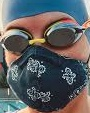

In [ ]:
cv2_imshow(image)

In [39]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


In [40]:
def iou_metric(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return intersection / (union + 1e-6)



In [41]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))


In [42]:

import tensorflow as tf


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))


#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy',iou_metric])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
non_segmented_dir = "/content/drive/My Drive/VR_MINI_C/face_crop"
segmented_dir = "/content/drive/My Drive/VR_MINI_C/face_crop_segmentation"

In [67]:
save_path1 = '/content/drive/MyDrive/non_segmented_images.npy'
save_path2 = '/content/drive/MyDrive/segmented_images.npy'


In [47]:
data_dir="/content/drive/My Drive/VR_MINI_C"

In [ ]:
non_segmented_images = np.load(save_path1)
segmented_images = np.load(save_path2)


In [69]:
def load_images(image_dir, img_size=(128, 128), save_path=None):
    images = []
    for img_name in os.listdir(image_dir):
      img_path = os.path.join(image_dir, img_name)
      img = cv2.imread(img_path)
      img = cv2.resize(img, img_size)  # Resize to target size
      images.append(img)
    images_array = np.array(images)
    # If a save path is provided, save the images array
    if save_path:
        np.save(save_path, images_array)  # Save as .npy file
        print(f"Images saved to {save_path}")
    return images_array

In [49]:

non_segmented_images = load_images(non_segmented_dir,save_path=save_path1)


Images saved to /content/drive/MyDrive/non_segmented_images.npy


In [50]:
segmented_images = load_images(segmented_dir,save_path=save_path2)

Images saved to /content/drive/MyDrive/segmented_images.npy


In [51]:
segmented_images = segmented_images / 255.0
non_segmented_images = non_segmented_images / 255.0


In [52]:
segmented_images = np.mean(segmented_images, axis=-1,keepdims=True)  # Shape: (N, 128, 128, 1)

In [53]:
len(segmented_images)

4500

In [72]:
len(test_images)

3372

In [73]:
test_images[0].max()

np.float64(1.0)

In [54]:
segmented_images[0].max()

np.float64(1.0)

In [55]:
len(non_segmented_images)

4500

In [56]:

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(non_segmented_images, segmented_images, test_size=0.2, random_state=42)


In [57]:
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)


<class 'numpy.ndarray'> (3600, 128, 128, 3)
<class 'numpy.ndarray'> (3600, 128, 128, 1)


In [59]:
history = model.fit(
    X_train,  # Input images
    y_train,  # Ground truth images
    batch_size=32,
    epochs=15,
    validation_data=(X_temp,y_temp),  # Split some training data for validation

)

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 611s 5s/step - accuracy: 0.4036 - iou_metric: 0.2780 - loss: 0.5729 - val_accuracy: 0.5237 - val_iou_metric: 0.6312 - val_loss: 0.2281
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 610s 5s/step - accuracy: 0.5437 - iou_metric: 0.6560 - loss: 0.2081 - val_accuracy: 0.5591 - val_iou_metric: 0.6875 - val_loss: 0.1863
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 627s 5s/step - accuracy: 0.5678 - iou_metric: 0.6954 - loss: 0.1798 - val_accuracy: 0.5594 - val_iou_metric: 0.6904 - val_loss: 0.1841
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 617s 5s/step - accuracy: 0.5662 - iou_metric: 0.6976 - loss: 0.1783 - val_accuracy: 0.5701 - val_iou_metric: 0.6970 - val_loss: 0.1790
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 624s 5s/step - accuracy: 0.5686 - iou_metric: 0.6985 - loss: 0.1777 - val_accuracy: 0.5663 - val_iou_metric: 0.6958 - val_loss: 0.1801
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 626s 5s/step - accuracy: 0.5679 - iou_metric: 0.6987 - loss: 0.1776 - val_accuracy: 0

In [25]:

# Paths to your directories
segmented_folder = '/content/drive/My Drive/VR_MINI_C/face_crop_segmentation'
non_segmented_folder = '/content/drive/My Drive/VR_MINI_C/face_crop'

# Get the list of image files in both directories
temp_segmented_images = set(os.listdir(segmented_folder))
temp_non_segmented_images = set(os.listdir(non_segmented_folder))

# Find common image names
common_images = temp_segmented_images.intersection(temp_non_segmented_images)

# Remove files from the segmented folder that don't have a matching file in the non-segmented folder
for file in temp_segmented_images:
    if file not in common_images:
        file_path = os.path.join(segmented_folder, file)
        os.remove(file_path)
        print(f'Removed: {file_path}')

# Remove files from the non-segmented folder that don't have a matching file in the segmented folder
for file in temp_non_segmented_images:
    if file not in common_images:
        file_path = os.path.join(non_segmented_folder, file)
        os.remove(file_path)
        print(f'Removed: {file_path}')

print("Finished removing unmatched files.")


Removed: /content/drive/My Drive/VR_MINI_C/face_crop/007492_8.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/007369_1.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/008145_2.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/007946_1.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/007438_1.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/007649_1.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/007593_2.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/007340_1.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/008113_1.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/008187_2.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/008129_1.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/007819_1.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/007837_1.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/007672_2.jpg
Removed: /content/drive/My Drive/VR_MINI_C/face_crop/007464_1.jpg
Removed: /

In [31]:
import os
import random

def delete_images_in_pairs(folder1, folder2, num_files=5000):
    if not os.path.exists(folder1) or not os.path.exists(folder2):
        print("One or both folders do not exist.")
        return

    # Get all image filenames (without extensions) in folder1
    images1 = set(f for f in os.listdir(folder1) if f.endswith(('.png', '.jpg', '.jpeg')))
    images2 = set(f for f in os.listdir(folder2) if f.endswith(('.png', '.jpg', '.jpeg')))

    # Get only the common files that exist in both folders
    common_files = list(images1.intersection(images2))

    if len(common_files) < num_files:
        print(f"Only {len(common_files)} common images found, deleting all.")
        num_files = len(common_files)

    # Select random files to delete
    files_to_delete = random.sample(common_files, num_files)

    # Delete images from both folders
    for file in files_to_delete:
        file_path1 = os.path.join(folder1, file)
        file_path2 = os.path.join(folder2, file)

        os.remove(file_path1)  # Delete from face_crop
        os.remove(file_path2)  # Delete from face_crop_segmentation

    print(f"Deleted {num_files} images from both {folder1} and {folder2}.")

# Specify folder paths
face_crop_folder = "path_to_face_crop"  # Change this to the actual folder path
face_crop_segmentation_folder = "path_to_face_crop_segmentation"  # Change this to the actual folder path

# Delete 5000 images in pairs
delete_images_in_pairs(non_segmented_dir, segmented_dir, num_files=3759)


Deleted 3759 images from both /content/drive/My Drive/VR_MINI_C/face_crop and /content/drive/My Drive/VR_MINI_C/face_crop_segmentation.


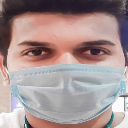

In [136]:
cv2_imshow(X_temp[0]*255)

In [140]:
mypred=model.predict(X_temp)

29/29 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step


In [141]:
len(mypred)

900

In [142]:
mypred[10]

array([[[2.61270721e-02],
        [8.89595365e-04],
        [1.18876842e-03],
        ...,
        [3.90815694e-05],
        [5.31143334e-04],
        [2.56028082e-02]],

       [[6.02412678e-04],
        [2.82312812e-05],
        [3.83588531e-06],
        ...,
        [5.93865843e-06],
        [5.90528580e-05],
        [2.61064502e-03]],

       [[3.00483400e-04],
        [7.05537673e-07],
        [1.34129063e-08],
        ...,
        [1.25254196e-09],
        [8.30779925e-08],
        [1.81630079e-04]],

       ...,

       [[7.38449919e-04],
        [8.38374419e-08],
        [1.72262504e-09],
        ...,
        [2.63256408e-19],
        [3.40728312e-09],
        [2.49530907e-09]],

       [[1.22636985e-02],
        [6.68399161e-06],
        [3.63993280e-07],
        ...,
        [8.42723515e-13],
        [3.01718728e-07],
        [2.33215019e-06]],

       [[4.18409333e-02],
        [1.08993240e-03],
        [2.25236733e-03],
        ...,
        [2.87435575e-10],
        [1.6804

In [149]:
binary_predictions = (mypred[0] > 0.5).astype("uint8") * 255

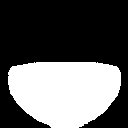

In [148]:
cv2_imshow(binary_predictions)